# Data Analysis of Prices

### Polars Preprocessing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

# These commands enlarge the column size of the dataframe so things like 0x... are not truncated
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
# load parquet file into polars dataframe polars dataframe
cow_uni_chain_outer_pl = pl.read_parquet('data/cow_uni_chain_outer_pl_historical.parquet')

In [3]:
cow_uni_chain_outer_pl.shape

(527322, 23)

In [4]:
cow_uni_chain_outer_pl.columns

['trades_timestamp',
 'swaps_blockNumber',
 'trades_txHash',
 'trades_feeAmount',
 'trades_sellToken_id',
 'trades_buyToken_id',
 'trades_sellAmount_converted',
 'trades_buyAmount_converted',
 'name',
 'environment',
 'swaps_pool_id',
 'swaps_tokenIn_id',
 'swaps_tokenOut_id',
 'swaps_amountIn_converted',
 'swaps_amountOut_converted',
 'transaction_gas_fee_one_hop',
 'transaction_gas_fee_median',
 'trades_buy_sell_ratio',
 'trades_sell_buy_ratio',
 'swaps_amountIn_amountOut_ratio',
 'swaps_amountOut_amountIn_ratio',
 'prices_assetPair_id',
 'prices_price']

In [5]:
cow_uni_chain_outer_pl.select([
    (pl.col("swaps_tokenOut_id")).value_counts(),
    (pl.col("trades_buyToken_id")).value_counts(),
]).rows()

[({'swaps_tokenOut_id': 'WETH', 'counts': 177275},
  {'trades_buyToken_id': 'WETH', 'counts': 15600}),
 ({'swaps_tokenOut_id': None, 'counts': 158544},
  {'trades_buyToken_id': None, 'counts': 477198}),
 ({'swaps_tokenOut_id': 'USDC', 'counts': 191503},
  {'trades_buyToken_id': 'USDC', 'counts': 34524})]

In [6]:
# return the larger value between trades_buy_sell_ratio and trades_sell_buy_ratio in a lambda function. This serves as a column equalization function for trades_buy_sell_ratio and trades_sell_buy_ratio
execution_prices_pl = cow_uni_chain_outer_pl.with_columns([
    (pl.col("trades_buy_sell_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_buy_sell_ratio'),
    (pl.col("trades_sell_buy_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_sell_buy_ratio'),
    (pl.col("swaps_amountIn_amountOut_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountIn_amountOut_ratio'),
    (pl.col("swaps_amountOut_amountIn_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountOut_amountIn_ratio'),
])

In [7]:
# Add trade directionality flag.
# we label the trade direction WETH -> USDC when WETH is in the CoW buy column and the UniV3 amountOut column. 
# Conversely, the USDC -> WETH direction is when USDC is in the CoW sell column and the Univ3 amountIn column.
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buyToken_id").apply(lambda x: True if x == 'WETH' else False)).alias('trades_buy_WETH'),
    (pl.col("swaps_tokenOut_id").apply(lambda x: True if x == 'WETH' else False)).alias('swaps_buy_WETH'),
])

In [8]:
# match cow trades with univ3 swaps
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buy_WETH") & pl.col("swaps_buy_WETH")).alias('buy_buy_WETH'), # cow buy/uni buy WETH
    (~pl.col("trades_buy_WETH") & ~pl.col("swaps_buy_WETH")).alias('sell_sell_WETH'), # cow sell/uni sell WETH
    (pl.col("trades_buy_WETH") & ~pl.col("swaps_buy_WETH")).alias('buy_sell_WETH'), # cow buy/uni sel WETH
    (~pl.col("trades_buy_WETH") & pl.col("swaps_buy_WETH")).alias('sell_buy_WETH'), # cow sell/uni buy WETH
])

### Pandas Preprocessing

In [9]:
# convert execution_prices_pl to pandas dataframe for easier plotting.
execution_prices_pd = execution_prices_pl.to_pandas()

# set trades_timestamp as index and order by trades_timestamp
execution_prices_pd = execution_prices_pd.set_index('trades_timestamp').sort_index()

# create a new dataframe with a unique integer index. make the current timestamp index a column
reindexed_df = execution_prices_pd.reset_index()

In [10]:
reindexed_price_df = reindexed_df[[
    'trades_timestamp',                     # timestamp
    'trades_sell_buy_ratio',                # cow price
    'swaps_amountOut_amountIn_ratio',       # univ3 price
    'prices_price',                         # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_buy_WETH',                          # cow/uni buy direction
    'sell_sell_WETH',                       # cow/uni sell direction
    'buy_sell_WETH',                        # cow buy/uni sell direction
    'sell_buy_WETH'                         # cow sell/uni buy direction
    ]]

# rename columns
reindexed_price_df.columns = [
    'timestamp',                            # timestamp
    'cow_price',                            # cow price
    'univ3_price',                          # univ3 price
    'chain_price',                          # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_buy_WETH',                          # trade direction
    'sell_sell_WETH',                       # trade direction
    'buy_sell_WETH',                        # trade direction
    'sell_buy_WETH'                         # trade direction
]

In [11]:
# forward fill reindexed_price_df
reindexed_price_df = reindexed_price_df.fillna(method='ffill')

In [12]:
reindexed_price_df.shape

(527322, 10)

In [13]:
# convert transaction_gas_fee into usd amount
reindexed_price_df['transaction_gas_fee_one_hop_usd'] = reindexed_price_df['transaction_gas_fee_one_hop'] * reindexed_price_df['univ3_price']
reindexed_price_df['transaction_gas_fee_median_usd'] = reindexed_price_df['transaction_gas_fee_median'] * reindexed_price_df['univ3_price']

In [14]:
# filter trade directions
buy_buy_WETH_reindex_df = reindexed_price_df[reindexed_price_df['buy_buy_WETH'] == True]
sell_sell_WETH_reindex_df = reindexed_price_df[reindexed_price_df['sell_sell_WETH'] == True]
buy_sell_WETH_reindex_df = reindexed_price_df[reindexed_price_df['buy_sell_WETH'] == True]
sell_buy_WETH_reindex_df = reindexed_price_df[reindexed_price_df['sell_buy_WETH'] == True]

In [15]:
# print f the df shapes
print(buy_buy_WETH_reindex_df.shape)
print(sell_sell_WETH_reindex_df.shape)
print(buy_sell_WETH_reindex_df.shape)
print(sell_buy_WETH_reindex_df.shape)

(3362, 12)
(9023, 12)
(2459, 12)
(4740, 12)


In [16]:
# get all values below the 90th percentile
buy_buy_WETH_df = buy_buy_WETH_reindex_df[buy_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < buy_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]
sell_sell_WETH_df = sell_sell_WETH_reindex_df[sell_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < sell_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]
buy_sell_WETH_df = buy_sell_WETH_reindex_df[buy_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < buy_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]
sell_buy_WETH_df = sell_buy_WETH_reindex_df[sell_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < sell_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]

In [35]:
print(f'cow and uni buy count: {buy_buy_WETH_df.shape}')
print(f'cow and uni sell count: {sell_sell_WETH_df.shape}')
print(f'cow buy and uni sell count: {buy_sell_WETH_df.shape}')
print(f'uni sell and cow buy count: {sell_buy_WETH_df.shape}')

cow and uni buy count: (3025, 14)
cow and uni sell count: (8120, 14)
cow buy and uni sell count: (2213, 14)
uni sell and cow buy count: (4263, 14)


In [19]:
# single hop gas adjusted prices
buy_buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_buy_WETH_df.loc[:, 'univ3_price'] + buy_buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
sell_sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_sell_WETH_df.loc[:, 'univ3_price'] - sell_sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
buy_sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_sell_WETH_df.loc[:, 'univ3_price'] - buy_sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
sell_buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_buy_WETH_df.loc[:, 'univ3_price'] + sell_buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']

# add new price values that add the gas cost
buy_buy_WETH_df.loc[:, 'univ3_gas_median_price'] = buy_buy_WETH_df.loc[:, 'univ3_price'] + buy_buy_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
sell_sell_WETH_df.loc[:, 'univ3_gas_median_price'] = sell_sell_WETH_df.loc[:, 'univ3_price'] - sell_sell_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
buy_sell_WETH_df.loc[:, 'univ3_gas_median_price'] = buy_sell_WETH_df.loc[:, 'univ3_price'] - buy_sell_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
sell_buy_WETH_df.loc[:, 'univ3_gas_median_price'] = sell_buy_WETH_df.loc[:, 'univ3_price'] + sell_buy_WETH_df.loc[:, 'transaction_gas_fee_median_usd']

/tmp/ipykernel_18225/807861930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_buy_WETH_df.loc[:, 'univ3_price'] + buy_buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
/tmp/ipykernel_18225/807861930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_sell_WETH_df.loc[:, 'univ3_price'] - sell_sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
/tmp/ipykernel_18225/807861930.py:

In [20]:
# convert index to datetime format
sell_sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_sell_WETH_df.timestamp, utc=True, unit='s')
buy_buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_buy_WETH_df.timestamp, utc=True, unit='s')
buy_sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_sell_WETH_df.timestamp, utc=True, unit='s')
sell_buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_buy_WETH_df.timestamp, utc=True, unit='s')

/tmp/ipykernel_18225/530421318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_sell_WETH_df.timestamp, utc=True, unit='s')
/tmp/ipykernel_18225/530421318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_buy_WETH_df.timestamp, utc=True, unit='s')
/tmp/ipykernel_18225/530421318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [21]:
# define color scheme
cow_color = '#0000b3'
univ3_color = '#993366'
chain_color = '#004d00'

In [43]:
# what is the date at the -2000th row for sell_sell_WETH_df?
print(sell_sell_WETH_df.iloc[-2000].timestamp)

graph_chart_date = sell_sell_WETH_df.iloc[-2000].timestamp

2022-10-08 20:19:35+00:00


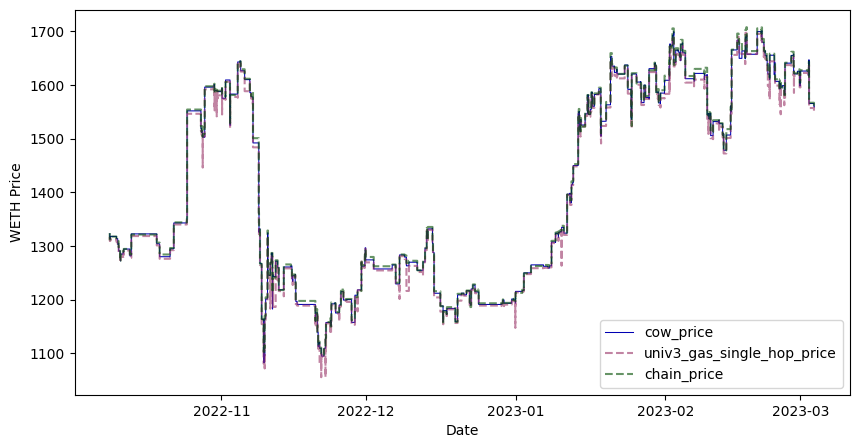

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [40]:
# plot prices on y axis and timestamp on x axis
fig1, ax = plt.subplots(figsize=(10, 5))
ax.step(
    sell_sell_WETH_df['timestamp'].iloc[-2000:], 
    sell_sell_WETH_df['cow_price'].iloc[-2000:], 
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    sell_sell_WETH_df['timestamp'].iloc[-2000:], 
    sell_sell_WETH_df['univ3_gas_single_hop_price'].iloc[-2000:], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    sell_sell_WETH_df['timestamp'].iloc[-2000:], 
    sell_sell_WETH_df['chain_price'].iloc[-2000:], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.show();

# save figure
fig1.savefig('../report/diagrams/weth_sell_line.eps', format='eps', bbox_inches='tight')
fig1.savefig('../report/diagrams/weth_sell_line.pdf', format='pdf', bbox_inches='tight')

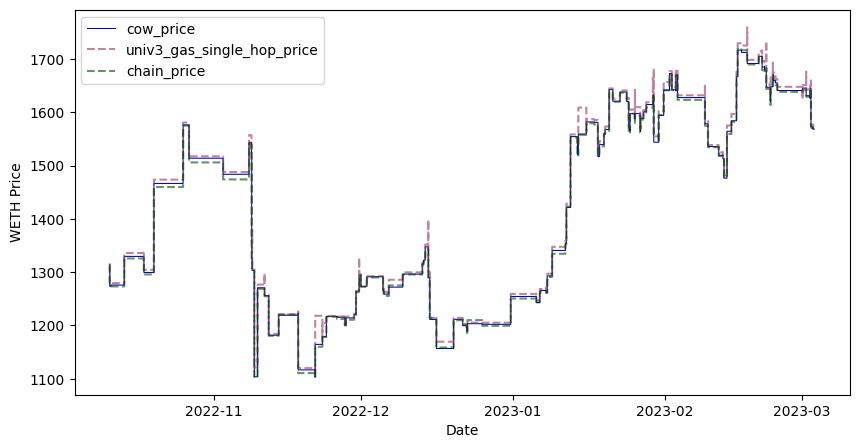

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [44]:
# plot buy_buy_WETH_df chart where the timestamp is after the graph_chart_date variable
fig2, ax = plt.subplots(figsize=(10, 5))
ax.step(
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['cow_price'],
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['univ3_gas_single_hop_price'], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['chain_price'], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.show();

fig2.savefig('../report/diagrams/weth_buy_line.eps', format='eps', bbox_inches='tight')
fig2.savefig('../report/diagrams/weth_buy_line.pdf', format='pdf', bbox_inches='tight')

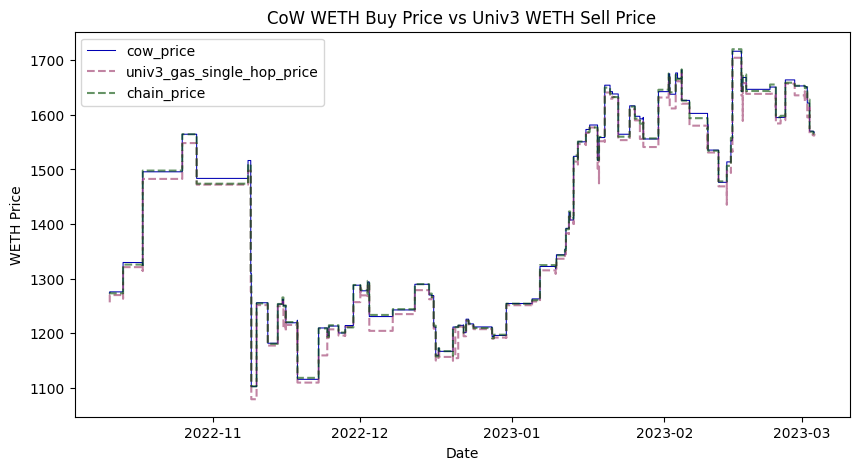

In [48]:
# plot prices on y axis and timestamp on x axis
fig3, ax = plt.subplots(figsize=(10, 5))
ax.step(
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['cow_price'],
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['univ3_gas_single_hop_price'], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['chain_price'], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.title('CoW WETH Buy Price vs Univ3 WETH Sell Price')
plt.show();

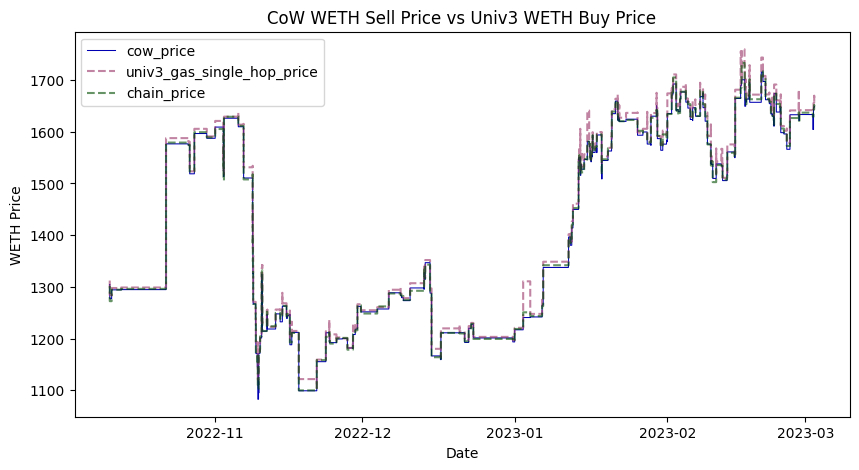

In [49]:
# plot prices on y axis and timestamp on x axis
fig4, ax = plt.subplots(figsize=(10, 5))
ax.step(
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['cow_price'],
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['univ3_gas_single_hop_price'], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['chain_price'], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.title('CoW WETH Sell Price vs Univ3 WETH Buy Price')
plt.show();

### Price Differences

In [50]:
# get the price price difference percent between cow and univ3 gas adjusted price in buy_buy_WETH_df
buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_single_hop_price']) / buy_buy_WETH_df['cow_price'] * 100
buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_median_price']) / buy_buy_WETH_df['cow_price'] * 100

/tmp/ipykernel_18225/2877689058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_single_hop_price']) / buy_buy_WETH_df['cow_price'] * 100
/tmp/ipykernel_18225/2877689058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_median_price']) / buy_buy_WETH_df['cow_

In [53]:
# get the price price difference percent between cow and univ3 gas adjusted price in sell_sell_WETH_df
sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_single_hop_price']) / sell_sell_WETH_df['cow_price'] * 100
sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_median_price']) / sell_sell_WETH_df['cow_price'] * 100

/tmp/ipykernel_18225/269593933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_single_hop_price']) / sell_sell_WETH_df['cow_price'] * 100
/tmp/ipykernel_18225/269593933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_median_price']) / sell_sell

In [51]:
# calculate mean deviation between cow and chain prices for each row
sell_sell_WETH_df['cow_chain_price_diff_percent'] = (sell_sell_WETH_df['chain_price'] - sell_sell_WETH_df['cow_price']) / sell_sell_WETH_df['cow_price'] * 100
buy_buy_WETH_df['cow_chain_price_diff_percent'] = (buy_buy_WETH_df['chain_price'] - buy_buy_WETH_df['cow_price']) / buy_buy_WETH_df['cow_price'] * 100

/tmp/ipykernel_18225/3633560276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df['cow_chain_price_diff_percent'] = (sell_sell_WETH_df['chain_price'] - sell_sell_WETH_df['cow_price']) / sell_sell_WETH_df['cow_price'] * 100
/tmp/ipykernel_18225/3633560276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df['cow_chain_price_diff_percent'] = (buy_buy_WETH_df['chain_price'] - buy_buy_WETH_df['cow_price']) / buy_buy_WETH_df['cow_price'] * 100


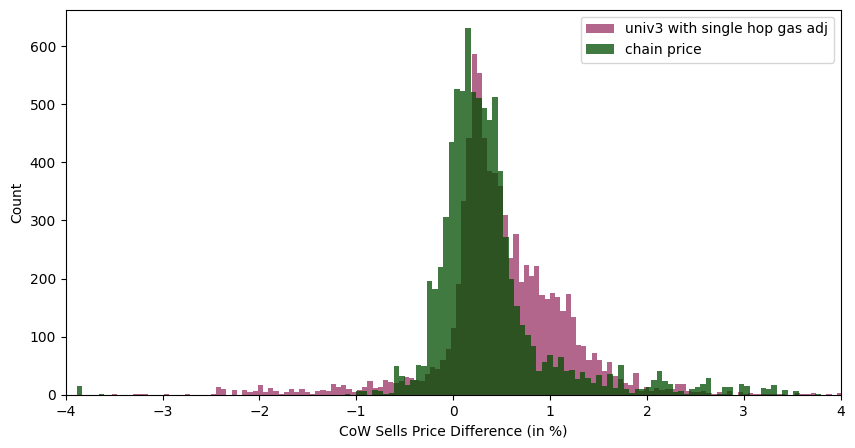

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [58]:
# plot histogram of the price diffs
# https://matplotlib.org/stable/gallery/misc/rasterization_demo.html
fig3, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'],
    bins=250,
    label='univ3 with single hop gas adj',
    color=univ3_color,
    alpha=0.75)
ax.hist(
    sell_sell_WETH_df['cow_chain_price_diff_percent'],
    bins=250,
    label='chain price',
    color=chain_color,
    alpha=0.75)

ax.set_xlim(-4, 4)
plt.xlabel('CoW Sells Price Difference (in %)')
plt.ylabel('Count')
plt.legend()
plt.show();

#save as eps
fig3.savefig('../report/diagrams/weth_sell_hist.eps', format='eps', bbox_inches='tight')
fig3.savefig('../report/diagrams/weth_sell_hist.pdf', format='pdf', bbox_inches='tight')

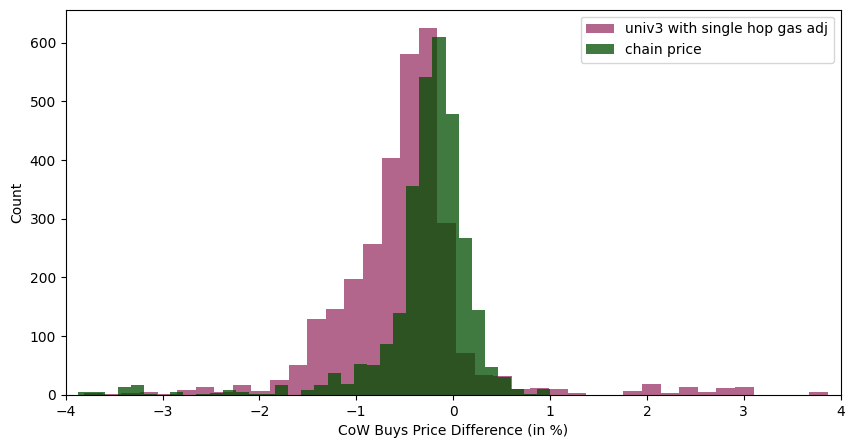

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [55]:
# plot histogram of the price diffs
fig3, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'],
    bins=50,
    label='univ3 with single hop gas adj',
    color=univ3_color,
    alpha=0.75)
ax.hist(
    buy_buy_WETH_df['cow_chain_price_diff_percent'],
    bins=50,
    label='chain price',
    color=chain_color,
    alpha=0.75)

ax.set_xlim(-4, 4)
plt.xlabel('CoW Buys Price Difference (in %)')
plt.ylabel('Count')
plt.legend()
plt.show();

#save as eps
fig3.savefig('../report/diagrams/weth_buy_hist.eps', format='eps', bbox_inches='tight')
fig3.savefig('../report/diagrams/weth_buy_hist.pdf', format='pdf', bbox_inches='tight')

In [59]:
# print the mean deviation of cow price from chainlink price with f strings
print(f"Mean deviation of cow sell price from chainlink price (90th percentile): {sell_sell_WETH_df['cow_chain_price_diff_percent'].mean():.2f}%")
print(f"Mean deviation of cow buy price from chainlink price (90th percentile): {buy_buy_WETH_df['cow_chain_price_diff_percent'].mean():.2f}%")

Mean deviation of cow sell price from chainlink price (90th percentile): 0.40%
Mean deviation of cow buy price from chainlink price (90th percentile): -0.33%


In [60]:
# statistics for buy_WETH_df single hop price difference
buy_buy_WETH_df[['transaction_gas_fee_one_hop_usd', 'univ3_gas_single_hop_price', 'cow_univ3_gas_adj_price_diff_percent_single', 'cow_chain_price_diff_percent']].describe()

,transaction_gas_fee_one_hop_usd,univ3_gas_single_hop_price,cow_univ3_gas_adj_price_diff_percent_single,cow_chain_price_diff_percent
count,3025.000000,3025.000000,3025.000000,3025.000000
mean,18.025399,2382.596568,-0.490217,-0.331296
std,16.116630,1099.064408,0.793871,0.727577
min,0.732861,994.671514,-4.962007,-5.763109
25%,4.317270,1473.485709,-0.821843,-0.402209
50%,11.880526,1789.679445,-0.470148,-0.182791
75%,29.684810,3499.365937,-0.230811,-0.032257
max,58.706795,4746.567563,4.636215,1.004717


In [61]:
sell_sell_WETH_df[['transaction_gas_fee_one_hop_usd', 'univ3_gas_single_hop_price', 'cow_univ3_gas_adj_price_diff_percent_single', 'cow_chain_price_diff_percent']].describe()

,transaction_gas_fee_one_hop_usd,univ3_gas_single_hop_price,cow_univ3_gas_adj_price_diff_percent_single,cow_chain_price_diff_percent
count,8120.000000,8120.000000,8120.000000,8120.000000
mean,19.518082,2406.210799,0.509903,0.402038
std,17.340280,1080.521093,0.730525,0.716555
min,0.410962,870.084837,-8.210004,-3.885598
25%,4.564326,1499.083181,0.207947,0.060359
50%,13.032172,1901.141354,0.442521,0.264827
75%,32.078104,3423.532941,0.862442,0.503743
max,62.298010,4639.877968,5.252639,10.231478
